# HUMAN ACTIVITY RECOGNITION

In this project, we elaborate on human activity recognition tracked by wearable shoe insoles that
have several sensors on them. The project's objective is to accurately predict a range of human activities.
The dataset is provided by a start-up company, Embry Tech, that has collected movement data among
several experiment participants. The methods used in the model building process are Correlation Analysis,
PCA, Binary Logistic Regression, Decision Tree, Random Forest and finally a Catboost Classifier for
multiclass classification. The findings illustrate that accurate prediction remains a complex task and while
very different activities such as sitting and running are easily distinguishable, more mixed activities such as
mixed walking and mixed walking that includes stairs up are more arduous to differentiate between

8 participants with different gender, age, height, and weight were recruited to perform 12 types of
activities: walking, mixed walking, jogging, climbing down, climbing up, stairs up, stairs down, mixed walking
that included stairs up movement, mixed walking with little pauses, standing, sitting and no activity at all.

**Import modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import statsmodels.tools as sm
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve
import scikitplot as skplt

#for not showing warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression

**Load data**

In [104]:
data=pd.read_csv('data_modeling_10s_MIX.csv', index_col=0)

In [105]:
data=data.drop(columns=['id'])

The dataset consisted of pressure and acceleration features that were captured by the sensors inside the insoles. The data were captured in three different locations inside the shoe insole resulting in effective vector data. For the purposes of feature engineering , first physical features were created. These were derived based on the physical interpretations of human motion. 

Specifically, two measures that are known to be significant predictors in HAR were computed

\begin{equation*}
MI(t) = \sqrt{a_x(t)^2+a_y(t)^2+a_z(t)^2} - Movement\text{ }Intensity
\end{equation*}
This feature is independent of the orientation of the sensing device, and measures the instantaneous intensity of human movements at index t

\begin{equation*}
SMA = \frac{1}{T}(\sum_{t=1}^T \lvert{a_x(t)}\rvert + \sum_{t=1}^T\lvert{a_y(t)}\rvert + \sum_{t=1}^T\lvert{a_z(t)}\rvert) - Normalized\text{ }Signal\text{ }Magnitude\text{ }Area
\end{equation*}
The acceleration magnitude summed over three axes within each window normalized by the window length.
This feature has been used in previous studies and is regarded as an indirect estimation of energy
expenditure.

In [106]:
data['intensity']=np.sqrt(data['x_mean']**2+data['y_mean']**2+data['z_mean']**2)/10
data['magnitude']=(data['x_mean']+data['y_mean']+data['z_mean'])/10
data['stdovermean1']=data['x_mean']/data['s1_std']
data['stdovermean2']=data['y_mean']/data['s1_std']
data['stdovermean3']=data['z_mean']/data['s1_std']

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Columns: 121 entries, s1_mean to stdovermean3
dtypes: float64(101), int64(18), object(2)
memory usage: 2.2+ MB


### Descriptive Analysis

Secondly, From these mechanical motion measurements different statistical parameters were computed. Through feature transformation a total of 122 features were gathered. Some commonly used features such as mean, variance, correlation and entropy were used. A few statistical measures were added such as mean over st.deviation of pressure. Some of them have been intensively investigated in previous studies and proved to be useful for activity recognition . For example, variance has been proved to achieve consistently high accuracy to differentiate activities such as walking, jogging, and hopping. On the other hand, Correlation between each pair of sensor axes helps differentiate activities that involve movement in a single dimension such as walking and running from the ones that involve movement in multi-dimension such as stair climbing.

In [13]:
data.describe()

,s1_mean,s2_mean,s3_mean,x_mean,y_mean,z_mean,s1_variation,s2_variation,s3_variation,x_variation,...,y_peak_prom_stand,x_y_corr,z_y_corr,x_z_corr,Kg,intensity,magnitude,stdovermean1,stdovermean2,stdovermean3
count,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,...,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,67.333220,46.546945,54.093338,174.347082,32.872267,-865.023091,0.912361,2.313199,1.246932,4.887602,...,4.609469,-0.309089,0.012921,-0.169316,63.812168,128.544277,-65.780374,3.795051,1.167127,-33.110362
std,36.172414,29.077740,41.319862,114.281857,113.398885,950.715905,22.508131,38.511866,4.589454,8.101204,...,4.048368,0.441664,0.249078,0.329147,12.181424,23.832157,97.962802,12.867751,11.922553,84.463746
min,-17.090000,-15.403750,-15.337500,-531.967500,-508.355000,-2209.037500,-1098.141072,-140.899750,-115.726957,-231.225070,...,0.000000,-0.958914,-0.954300,-0.947648,52.000000,72.824999,-188.933250,-148.191302,-151.763990,-362.906654
25%,46.126559,27.452500,10.064509,97.859739,-69.785000,-1403.010476,1.096088,0.991677,0.419846,2.479409,...,0.000000,-0.640489,-0.137875,-0.404316,53.500000,102.567879,-117.231301,1.124048,-0.874795,-17.736953
50%,67.611523,47.252808,56.271644,176.081278,49.955206,-1227.791250,1.312785,1.345413,1.278816,4.645390,...,5.482471,-0.478998,0.030955,-0.281473,63.700000,133.178591,-98.548616,1.646823,0.571191,-12.165795
75%,90.984809,66.601562,74.254446,230.855360,114.811563,-982.281875,1.761023,1.876336,1.628066,6.478402,...,7.087208,-0.036298,0.181931,0.021127,63.700000,144.000239,-79.629000,3.568488,1.211837,-9.636322
max,238.155689,230.512974,302.381238,632.875000,603.715000,1741.845000,25.304658,1772.503879,137.673569,219.930945,...,24.857143,0.974355,0.940266,0.942150,89.200000,228.944748,218.399500,141.385988,169.956511,302.566483


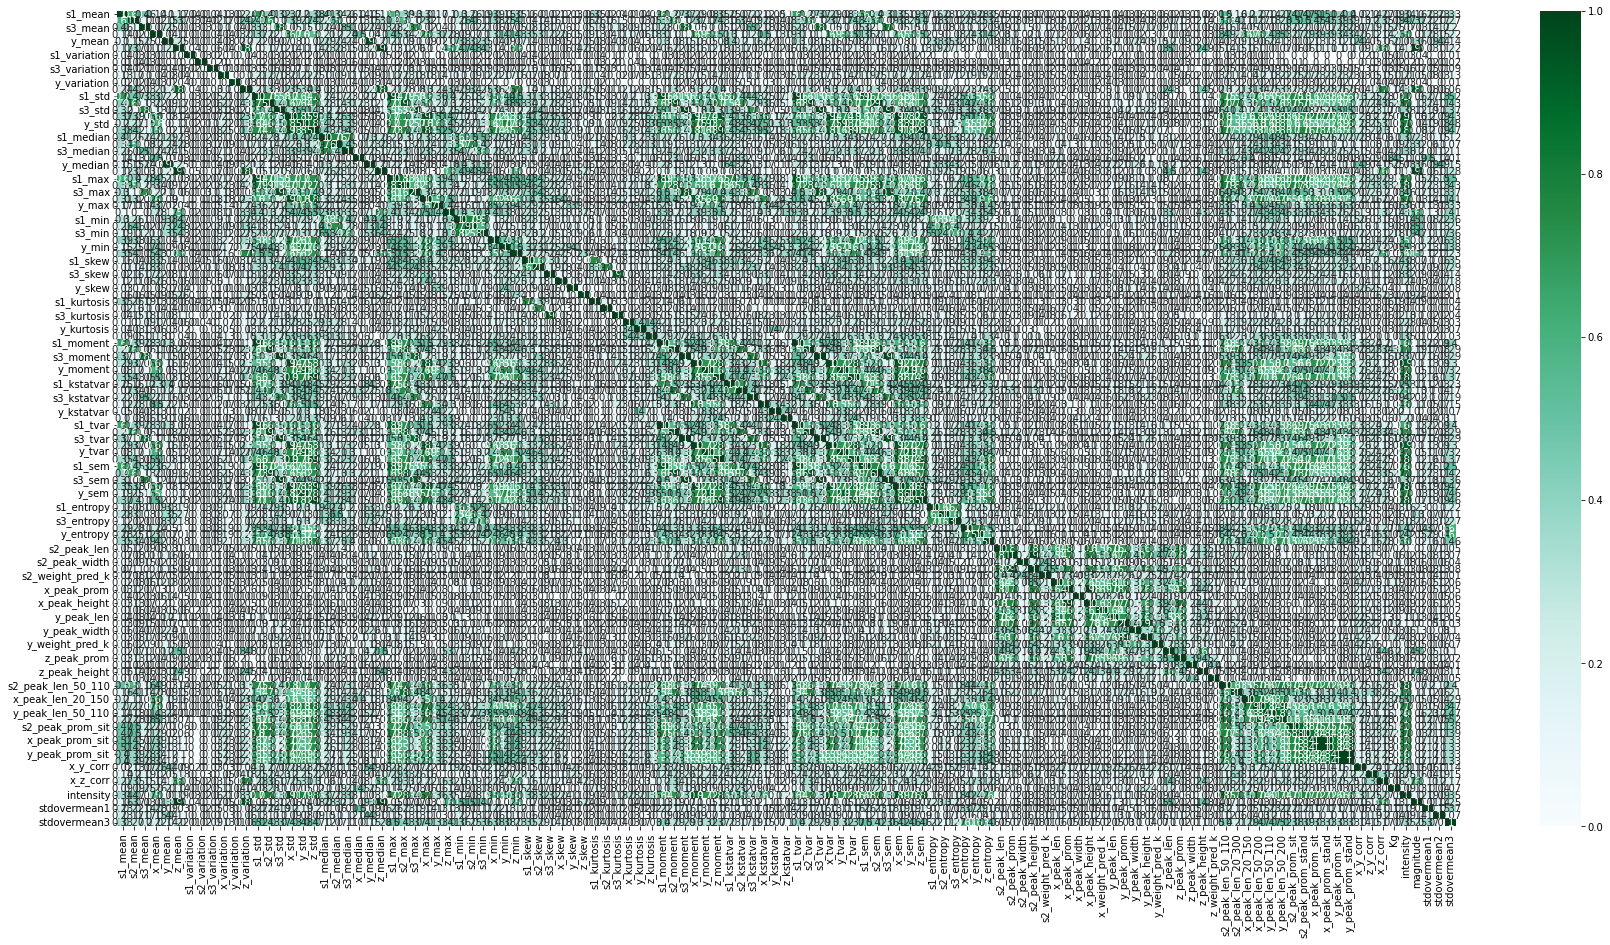

In [139]:
plt.figure(figsize=(30,15))
sns.heatmap(data.corr().abs().round(2),annot=True, cmap = "BuGn")
plt.show()

**correlation**

The problem, however, was that some of the features were irrelevant and redundant, showing high correlation with other features. These features were not adding new information to improve the classification accuracy, as well as the high dimensionality was confusing the classifiers rather than helping them. The image below shows the pairwise correlation of features. Dark greens represent correlation of more than 0.75.

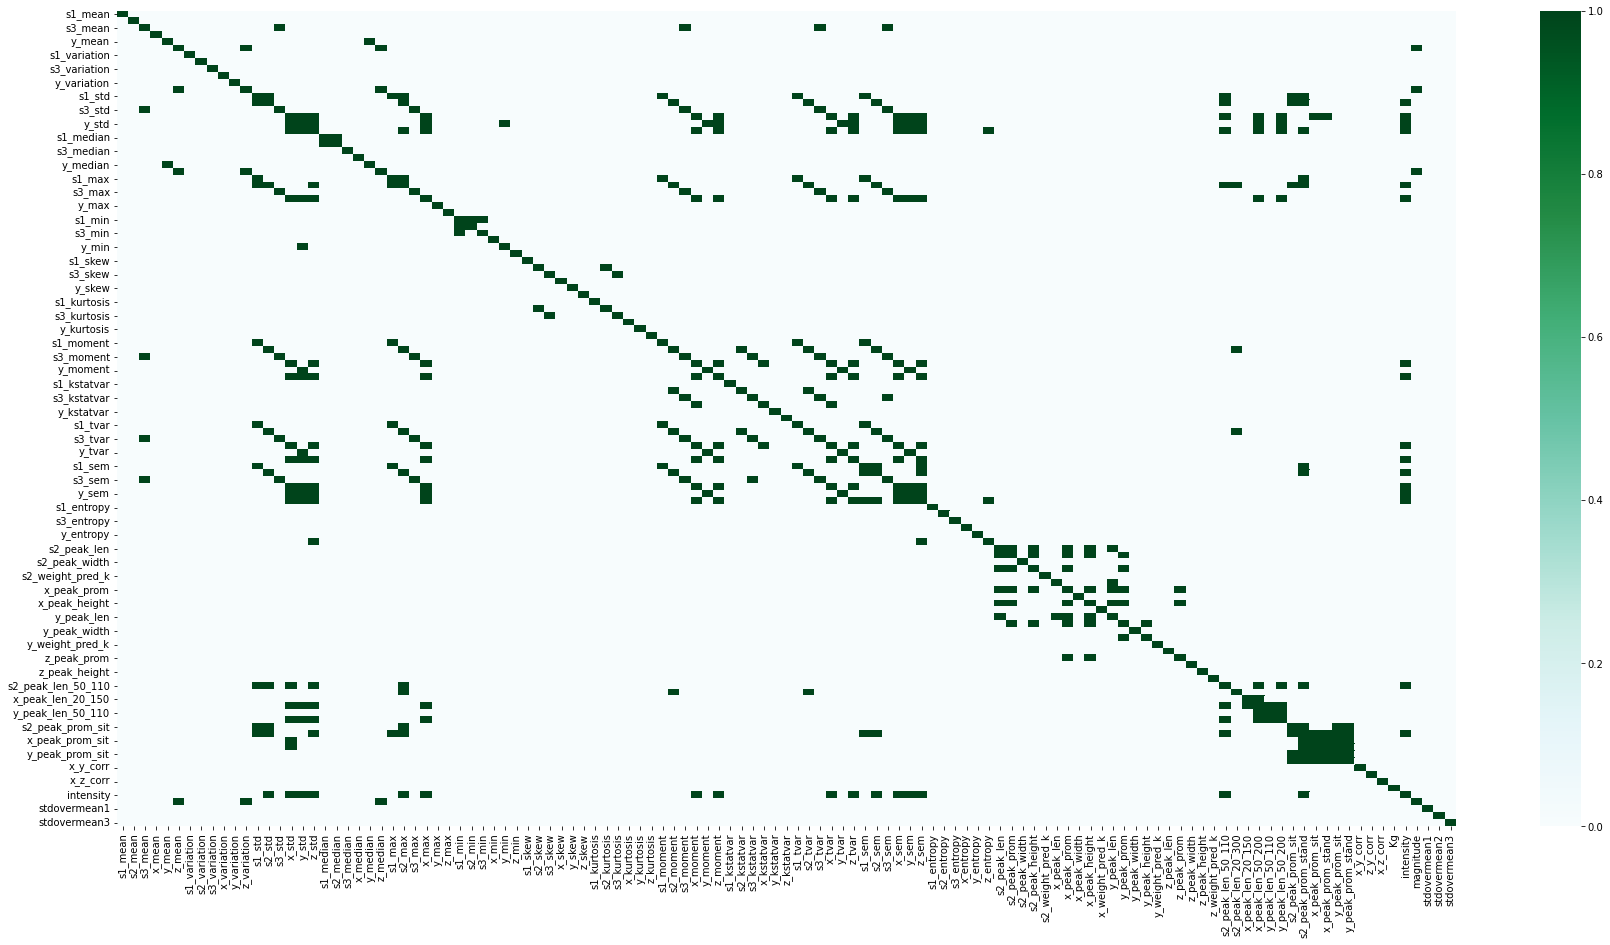

In [124]:
plt.figure(figsize=(30,15))
sns.heatmap(data.corr().abs()>=0.75, cmap = "BuGn")
plt.show()

To achieve the best classification performance the dimensionality was reduced. We used a correlation-based feature selection method to select a subset of features. All the variables that had a correlation of more than 0.75 were excluded from the set. Only complementary features were kept. This is important not only in terms of more accurate prediction, but also it may result in less computational costs for the company

In [30]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


In [164]:
#the benchmark for Target 
data.Target.value_counts(normalize=True).mul(100).rename("Target percentage")

Walking                               26.121262
Mixed walking                         26.121262
Sitting                               10.672757
Standing                               9.593023
Jogging                                8.098007
Climbing down                          5.481728
Climbing up                            4.983389
Stairs up                              4.360465
Stairs down                            2.657807
Mixed walking  with little pauses      0.789037
Mixed walking  includes stairs up      0.622924
No activity                            0.498339
Name: Target percentage, dtype: float64

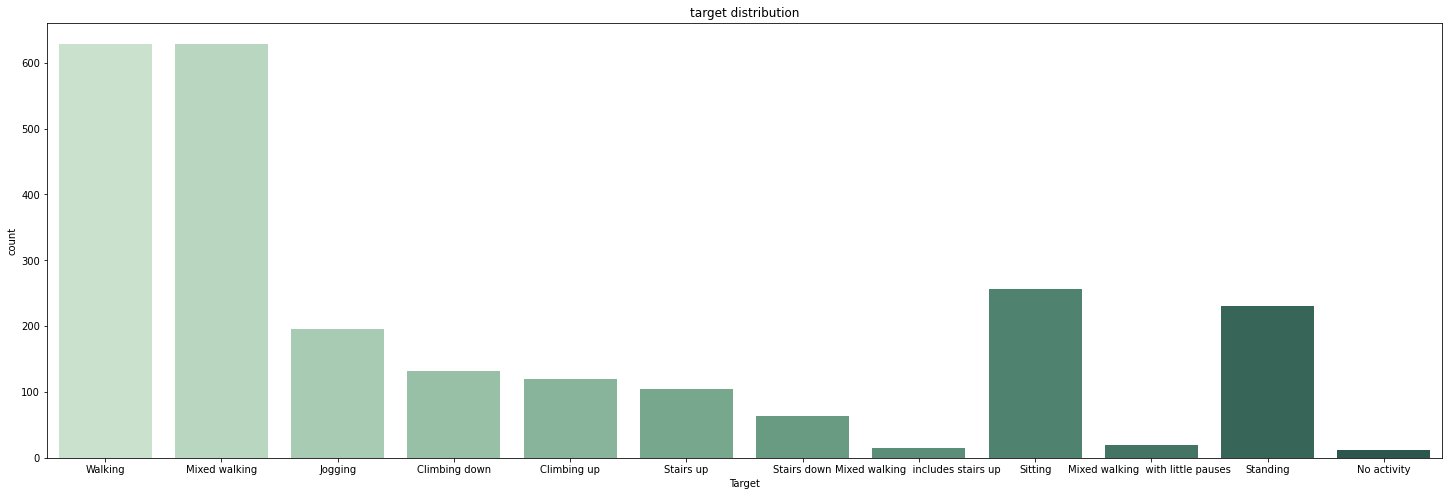

In [165]:
#the distribution of target
plt.figure(figsize=(25,8))
sns.countplot(data.Target, palette="ch:2.5,-.2,dark=.3")
plt.title("target distribution")
plt.show()

In [166]:
data['Target'].tail(100)

2308    Mixed walking
2309    Mixed walking
2310    Mixed walking
2311    Mixed walking
2312    Mixed walking
            ...      
2403          Sitting
2404          Sitting
2405          Sitting
2406          Sitting
2407          Sitting
Name: Target, Length: 100, dtype: object

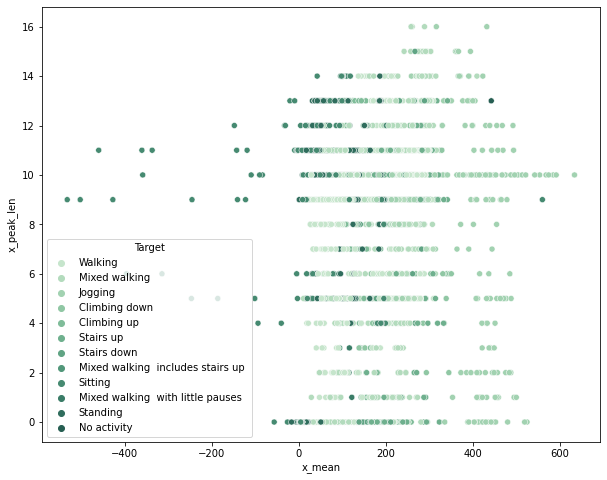

In [167]:
plt.figure(figsize=(10,8))
a = sns.scatterplot(x="x_mean", y="x_peak_len", hue="Target",palette="ch:2.5,-.2,dark=.3"
                     , data=data)

As we can see from the scatterplot below, no-movement activities that are colored in darker green seem to have clustered in the beginning of these two dot streams.

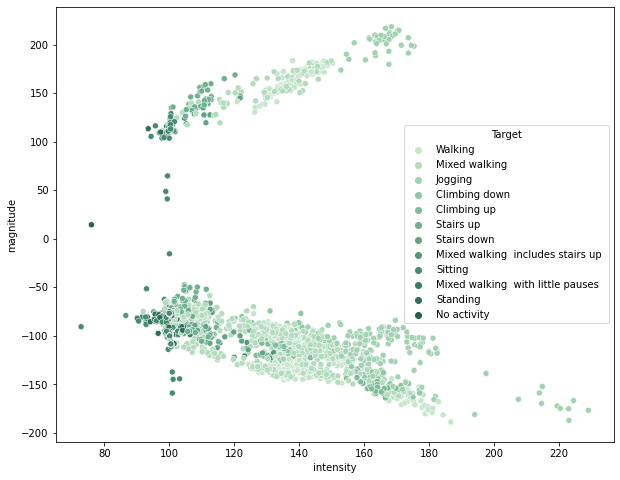

In [15]:
plt.figure(figsize=(10,8))
b=  sns.scatterplot(x="intensity", y="magnitude", hue="Target", palette="ch:2.5,-.2,dark=.3",
                     data=data)

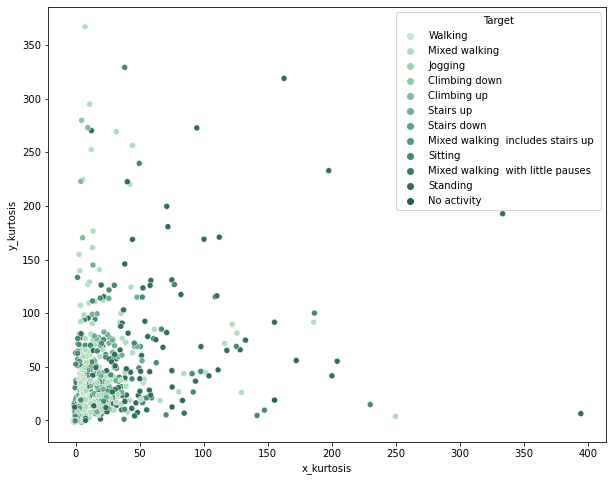

In [16]:
plt.figure(figsize=(10,8))
b=  sns.scatterplot(x="x_kurtosis",y="y_kurtosis", hue="Target", palette="ch:2.5,-.2,dark=.3",
                     data=data)

In [108]:
# Create correlation matrix with the original data
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Drop features 
data= data.drop(data[to_drop], axis=1)

In [110]:
data2 = data.copy() #For multiclass 
data3 = data.copy()

### Models

In this paper, we have used three different machine learning algorithms to classify the target variable. For that purpose we have splitted the target into two categories that define whether the human wearing the insole is moving or not. The categories of sitting, standing and no activity were combined to represent no movement and the rest to represent some movement, e.g. walking, mixed walking. 

In [33]:
data['Target'] = np.where((data['Target']=='Sitting') | (data['Target']=='Standing') | (data['Target']=='No activity'), 1, 0)

Dummies for persons recruited for the experiment were used to identify whether there is a person specific component in target activities.

In [34]:
data=pd.get_dummies(data, drop_first=True)

In [36]:
#sepparating data
Y=data["Target"]
X=data.drop("Target",axis=1)

In [37]:
#adding constant
X=sm.add_constant(X)

As the data set suffered from high-dimensionality it was divided into training and testing sets for validating the model accuracy on test data as well. The splitting was done manually to avoid random splits that would include the same person both in train and test.

In [38]:
#splitting the data manually
#split Y into two parts - get Y0, Y1 
#split X into two parts - get X0, Y0 
#X1,Y1-> test, X0, Y0-> train
Y1=Y[:217]
Y0=Y[-2191:]
X1=X[:217]
X0=X[-2191:]

**Logistic Regression**

We have used multinomial logistic regression algorithms that might be useful not only for prediction but also for identifying important features and eliminating unimportant ones. This approach may remarkably reduce the dimension and maintain the most discriminative information. 

In [39]:
model=Logit(Y0,X0)
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.036329
         Iterations 14


In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                 2191
Model:                          Logit   Df Residuals:                     2124
Method:                           MLE   Df Model:                           66
Date:                Sat, 19 Feb 2022   Pseudo R-squ.:                  0.9295
Time:                        12:09:21   Log-Likelihood:                -79.596
converged:                       True   LL-Null:                       -1128.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9214   1.27e+07  -7.28e-08      1.000   -2.48e+07    2.48e+07
s1_mean               0.0684      0.049      1.406      0.160      -0.027       0.164
s2_mean               0.0653      0.038      1.739      0.082      -0.008       0.139
s3_mean              -0.1405      0.037     -3.816      0.000      -0.213      -0.068
x_mean               -0.0814      0.021     -3.855      0.000      -0.123      -0.040
y_mean                0.0087      0.011      0.772      0.440      -0.013       0.031
z_mean                0.0011      0.006      0.183      0.855      -0.011       0.013
s1_variation         -0.0085      0.021     -0.395      0.693      -0.051       0.034
s2_variation         -0.0593      0.135     -0.441      0.659      -0.323       0.205
s3_variation         -0.1022      0.053     -1.943      0.052      -0.205       0.001
x_variation           0.0053      0.015      0.341      0.733      -0.025       0.036
y_variation          -0.0530      0.028     -1.909      0.056      -0.107       0.001
s1_std               -0.0763      0.031     -2.466      0.014      -0.137      -0.016
x_std                -0.0067      0.004     -1.775      0.076      -0.014       0.001
s1_median            -0.0464      0.032     -1.451      0.147      -0.109       0.016
s3_median             0.0631      0.031      2.047      0.041       0.003       0.124
x_median              0.0125      0.017      0.753      0.451      -0.020       0.045
y_max                 0.0003      0.001      0.622      0.534      -0.001       0.001
z_max                -0.0004      0.001     -0.608      0.543      -0.002       0.001
s1_min                0.0180      0.035      0.509      0.611      -0.051       0.087
x_min                 0.0012      0.001      1.364      0.172      -0.001       0.003
z_min                 0.0006      0.000      1.462      0.144      -0.000       0.001
s1_skew               0.7133      0.571      1.250      0.211      -0.405       1.832
s2_skew               0.5594      0.530      1.056      0.291      -0.479       1.598
s3_skew              -0.4704      0.447     -1.051      0.293      -1.347       0.406
x_skew               -0.0714      0.076     -0.935      0.350      -0.221       0.078
y_skew               -0.1199      0.078     -1.537      0.124      -0.273       0.033
z_skew                0.0032      0.049      0.065      0.948      -0.093       0.100
s1_kurtosis          -0.1687      0.150     -1.125      0.261      -0.463       0.125
x_kurtosis           -0.0039      0.006     -0.661      0.509      -0.016       0.008
y_kurtosis           -0.0074      0.006     -1.211      0.226      -0.019       0.005
z_kurtosis            0.0020      0.004      0.540      0.589      -0.005       0.009
s1_kstatvar       -1.715e-06   1.03e-06     -1.667      0.096   -3.73e-06    3.01e-07
y_kstatvar         8.394e-11   6.06e-11      1.385      0.166   -3.48e-11    2.03e-10
z_kstatvar         2.519e-11   4.61e-11      0.546      0.5

In [41]:
results.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 Target
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
s1_mean               0.0007      0.001      1.480      0.139      -0.000       0.002
s2_mean               0.0007      0.000      1.772      0.076   -7.58e-05       0.002
s3_mean              -0.0015      0.000     -4.369      0.000      -0.002      -0.001
x_mean               -0.0009      0.000     -3.912      0.000      -0.001      -0.000
y_mean             9.462e-05      0.000      0.787      0.431      -0.000       0.000
z_mean             1.205e-05   6.59e-05      0.183      0.855      -0.000       0.000
s1_variation      -9.268e-05      0.000     -0.370      0.711      -0.001       0.000
s2_variation         -0.0006      0.002     -0.372      0.710      -0.004       0.003
s3_variation         -0.0011      0.000     -3.019      0.003      -0.002      -0.000
x_variation        5.767e-05      0.000      0.330      0.741      -0.000       0.000
y_variation          -0.0006      0.000     -2.134      0.033      -0.001   -4.72e-05
s1_std               -0.0008      0.000     -2.907      0.004      -0.001      -0.000
x_std             -7.305e-05   3.84e-05     -1.903      0.057      -0.000     2.2e-06
s1_median            -0.0005      0.000     -1.474      0.140      -0.001       0.000
s3_median             0.0007      0.000      2.173      0.030    6.74e-05       0.001
x_median              0.0001      0.000      0.737      0.461      -0.000       0.000
y_max              3.823e-06   6.09e-06      0.628      0.530   -8.11e-06    1.58e-05
z_max             -3.882e-06   6.42e-06     -0.605      0.545   -1.65e-05     8.7e-06
s1_min                0.0002      0.000      0.511      0.610      -0.001       0.001
x_min              1.274e-05   9.16e-06      1.390      0.164   -5.22e-06    3.07e-05
z_min              6.593e-06    4.3e-06      1.532      0.126   -1.84e-06     1.5e-05
s1_skew               0.0078      0.006      1.335      0.182      -0.004       0.019
s2_skew               0.0061      0.006      1.052      0.293      -0.005       0.017
s3_skew              -0.0051      0.005     -1.096      0.273      -0.014       0.004
x_skew               -0.0008      0.001     -0.955      0.339      -0.002       0.001
y_skew               -0.0013      0.001     -1.568      0.117      -0.003       0.000
z_skew             3.506e-05      0.001      0.065      0.948      -0.001       0.001
s1_kurtosis          -0.0018      0.002     -1.172      0.241      -0.005       0.001
x_kurtosis        -4.304e-05   6.48e-05     -0.664      0.507      -0.000     8.4e-05
y_kurtosis        -8.036e-05    6.5e-05     -1.236      0.216      -0.000     4.7e-05
z_kurtosis         2.214e-05   4.08e-05      0.543      0.587   -5.78e-05       0.000
s1_kstatvar       -1.873e-08   1.09e-08     -1.715      0.086   -4.01e-08    2.67e-09
y_kstatvar         9.168e-13   6.43e-13      1.426      0.154   -3.44e-13    2.18e-12
z_kstatvar         2.751e-13   5.01e-13      0.549      0.583   -7.07e-13    1.26e-12
s1_entropy           -0.0032      0.002     -1.406      0.160      -0.008       0.001
s2_entropy           -0.0024      0.002     -1.278      0.201      -0.006       0.001
s3_entropy           -0.0017      0.002     -0.993      0.321      -0.005       0.002
x_entropy             0.0008      0.001      0.550      0.582      -0.002       0.004
y_entropy             0.0022      0.002      1.157      0.247      -0.002       0.006
s2_peak_len          -0.0046      0.002     -2.564      0.010      -0.008      -0.001
s2_peak_width        -0.0008      0.001     -1.443      0.149   

Preliminary logistic regression showed a big number of insignificant features. Using backward elimination technique and closely following the predictive power of the model we removed some of the variables. We have optimized all three models through hyperparameter optimization and finding the best parameters for all three models.

In [53]:
results.pred_table().T

array([[1709.,   13.],
       [  20.,  449.]])

In [54]:
results.pred_table(0.7).T

array([[1721.,   25.],
       [   8.,  437.]])

In [55]:
Y1_hat=results.predict(X1)
Y0_hat=results.predict(X0)

In [56]:
Y1_class=np.where(Y1_hat>=0.5,1,0)
Y0_class=np.where(Y0_hat>=0.5,1,0)

In [57]:
print("ROC_AUC Train:",roc_auc_score(Y0,Y0_hat).round(2))
print("ROC_AUC Test:",roc_auc_score(Y1,Y1_hat).round(2))

ROC_AUC Train: 1.0
ROC_AUC Test: 0.97


In [58]:
#confusion matrix for the train data
cm_train=confusion_matrix(Y0,Y0_class).T

In [59]:
print("Accuracy_train:", (cm_train[0,0]+cm_train[1,1])/len(Y0))
print("Sensitivity_train:",cm_train[1,1]/(cm_train[1,1]+cm_train[0,1]))
print("Specificity_train:",cm_train[0,0]/(cm_train[0,0]+cm_train[1,0]))

Accuracy_train: 0.9849383842994066
Sensitivity_train: 0.9718614718614719
Specificity_train: 0.9884326200115674


In [60]:
#confusion matrix for the test data
cm_test=confusion_matrix(Y1,Y1_class).T

In [61]:
#let's calculate overall accuracy, recall and specificity for test data
print("Accuracy_test:", (cm_test[0,0]+cm_test[1,1])/len(Y1))
print("Sensitivity_test:",cm_test[1,1]/(cm_test[1,1]+cm_test[0,1]))
print("Specificity_test:",cm_test[0,0]/(cm_test[0,0]+cm_test[1,0]))

Accuracy_test: 0.9493087557603687
Sensitivity_test: 0.9210526315789473
Specificity_test: 0.9553072625698324


In [62]:
#calculating using classification report
print("Logistic Regression Train:")
print(classification_report(Y0,Y0_class))

print("Logistic Regression Test:")
print(classification_report(Y1,Y1_class))

Logistic Regression Train:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1729
           1       0.96      0.97      0.96       462

    accuracy                           0.98      2191
   macro avg       0.97      0.98      0.98      2191
weighted avg       0.99      0.98      0.98      2191

Logistic Regression Test:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       179
           1       0.81      0.92      0.86        38

    accuracy                           0.95       217
   macro avg       0.90      0.94      0.92       217
weighted avg       0.95      0.95      0.95       217



Going beyond the accuracy of the model we see that for the test data Logistic Regression had a
precision of 0.81. for positive cases (not moving). Precision is defined as the number of true positives
divided by the number of true positives plus the number of false positives. False positives are cases the
model incorrectly labels as positive that are actually negative, or in our example, individuals the model
classifies as not moving(1) while they are moving (0). While recall expresses the ability to find all relevant
instances in a dataset, precision expresses the proportion of the data points our model says was relevant
actually were relevant

In [63]:
# we can also calculate accuracy, recall and ROC_AUC score using respective metrics from sklearn library
#summarizing the results into a dataframe
results_summary=pd.DataFrame({"Accuracy":[accuracy_score(Y0,Y0_class),accuracy_score(Y1,Y1_class)],
                              "ROC_AUC":[roc_auc_score(Y0,Y0_hat),roc_auc_score(Y1, Y1_hat)],
                              "Recall":[recall_score(Y0, Y0_class),recall_score(Y1, Y1_class)]
                              },
                             index=["Training set","Testing set"])
results_summary

,Accuracy,ROC_AUC,Recall
Training set,0.984938,0.998736,0.971861
Testing set,0.949309,0.971626,0.921053


Preliminary logistic regression showed a big number of insignificant features. Using backward
elimination technique and closely following the predictive power of the model we removed some of the
variables. We have optimized all three models through hyperparameter optimization and finding the best
parameters for all three models.

**Decision Tree**

In [64]:
dt=DecisionTreeClassifier(random_state=1)
dt.fit(X0,Y0)

DecisionTreeClassifier(random_state=1)

In [65]:
#calculating probabilities
Y0_dt=dt.predict_proba(X0)[:,1]
Y1_dt=dt.predict_proba(X1)[:,1]

In [66]:
#setting up parameters for DT's GridSearch
param_dt={"max_depth":range(1,15),
          "min_samples_leaf":range(10,150,10),
          "class_weight":["balanced",None]        
            }

In [67]:
#fitting GridSearch with above specified parameters
gs_dt=GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), param_grid=param_dt,
                  scoring="roc_auc",cv=5)
gs_dt.fit(X0,Y0)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': range(1, 15),
                         'min_samples_leaf': range(10, 150, 10)},
             scoring='roc_auc')

In [68]:
gs_dt.best_params_

{'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 60}

In [69]:
#fitting the model with best parameters
dt_grid=DecisionTreeClassifier(class_weight='balanced',max_depth=4,min_samples_leaf=60, random_state=1).fit(X0,Y0)

In [70]:
Y0_dt_grid=dt_grid.predict_proba(X0)[:,1]
Y1_dt_grid=dt_grid.predict_proba(X1)[:,1]
print("ROC_AUC Train for tuned DT:",roc_auc_score(Y0,Y0_dt_grid).round(2))
print("ROC_AUC Test for tuned DT:",roc_auc_score(Y1,Y1_dt_grid).round(2))
print("Mean 5-fold ROC AUC score for Tuned DT",np.mean(cross_val_score(estimator=dt_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train for tuned DT: 0.99
ROC_AUC Test for tuned DT: 0.96
Mean 5-fold ROC AUC score for Tuned DT 0.97


**Logit with best parameters**

In [73]:
#building GridSearch with Logistic Regression
logit=LogisticRegression(random_state=1)

param_logit={"class_weight":["balanced",None],
            "C":np.linspace(0.0001,50,20)}


gs_logit=GridSearchCV(estimator=logit,
                      param_grid=param_logit,
                      scoring="roc_auc", cv=5, verbose=1, n_jobs=2).fit(X0,Y0) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [74]:
#finding out the best parameters
gs_logit.best_params_

{'C': 26.31583684210526, 'class_weight': None}

In [75]:
#building logit with best params and seeing the results
logit_grid=LogisticRegression(C=0.0001,class_weight='balanced',random_state=1).fit(X0,Y0)

Y0_logit=logit_grid.predict_proba(X0)[:,1]
Y1_logit=logit_grid.predict_proba(X1)[:,1]
print("ROC_AUC Train for tuned Logit:",roc_auc_score(Y0,Y0_logit).round(2))
print("ROC_AUC Test for tuned Logit:",roc_auc_score(Y1,Y1_logit).round(2))
print("Mean 5-fold ROC AUC score for Tuned Logit",np.mean(cross_val_score(estimator=logit_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train for tuned Logit: 0.95
ROC_AUC Test for tuned Logit: 0.98
Mean 5-fold ROC AUC score for Tuned Logit 0.95


In [76]:
print(param_dt)

{'max_depth': range(1, 15), 'min_samples_leaf': range(10, 150, 10), 'class_weight': ['balanced', None]}


**Random Forest**

In [77]:
#building GridSearch for RF using DT's hyperparameters ranges
gs_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=1),
                  param_grid=param_dt, scoring="roc_auc", cv=3, n_jobs=2).fit(X0,Y0)

In [78]:
#outlining best parameters
gs_rf.best_params_

{'class_weight': None, 'max_depth': 7, 'min_samples_leaf': 10}

In [79]:
#building RF with the best parameters
rf_grid=RandomForestClassifier(class_weight=None,max_depth=4,min_samples_leaf=20, random_state=1).fit(X0,Y0)

Y0_rf_grid=rf_grid.predict_proba(X0)[:,1]
Y1_rf_grid=rf_grid.predict_proba(X1)[:,1]
print("ROC_AUC Train for tuned RF:",roc_auc_score(Y0,Y0_rf_grid).round(2))
print("ROC_AUC Test for tuned RF:",roc_auc_score(Y1,Y1_rf_grid).round(2))
print("Mean 5-fold ROC AUC score for Tuned RF",np.mean(cross_val_score(estimator=rf_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train for tuned RF: 1.0
ROC_AUC Test for tuned RF: 0.99
Mean 5-fold ROC AUC score for Tuned RF 0.99


In [84]:
Y1_hat=rf_grid.predict(X1)
Y0_hat=rf_grid.predict(X0)
Y1_class=np.where(Y1_hat>=0.5,1,0)
Y0_class=np.where(Y0_hat>=0.5,1,0)
#calculating using classification report
print("Random Forest Train:")
print(classification_report(Y0,Y0_class))

print("Random Forest Test:")
print(classification_report(Y1,Y1_class))

Random Forest Train:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1729
           1       0.91      0.97      0.94       462

    accuracy                           0.97      2191
   macro avg       0.95      0.97      0.96      2191
weighted avg       0.97      0.97      0.97      2191

Random Forest Test:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       179
           1       0.86      0.95      0.90        38

    accuracy                           0.96       217
   macro avg       0.92      0.96      0.94       217
weighted avg       0.97      0.96      0.96       217



Random Forest gave a good-enough result in terms of its accuracy to predict the occurrence of an
event on unseen data.

In [80]:
#As we see, Random Forest outperforms the two other models on mean 5-fold cross validation score.

print("Mean 5-fold ROC AUC score for Tuned DT",np.mean(cross_val_score(estimator=dt_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))
print("Mean 5-fold ROC AUC score for Tuned RF",np.mean(cross_val_score(estimator=rf_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))
print("Mean 5-fold ROC AUC score for Tuned Logit",np.mean(cross_val_score(estimator=logit_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned DT 0.97
Mean 5-fold ROC AUC score for Tuned RF 0.99
Mean 5-fold ROC AUC score for Tuned Logit 0.95


In [82]:
#setting up the needed metrics
FPR, TPR, thresholds=roc_curve(Y1, rf_grid.predict_proba(X1)[:,1])

An ROC curve was constructed for the winning model (RF) by plotting the true positive rate (TPR) against
the false positive rate (FPR).

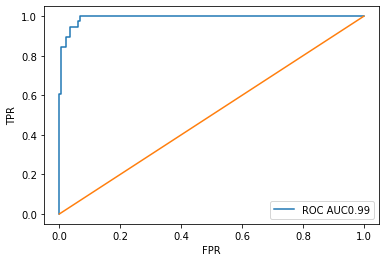

In [83]:
#plotting ROC AUC for Random Forest
plt.plot(FPR, TPR, label=f"ROC AUC{roc_auc_score(Y1,rf_grid.predict_proba(X1)[:,1]).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

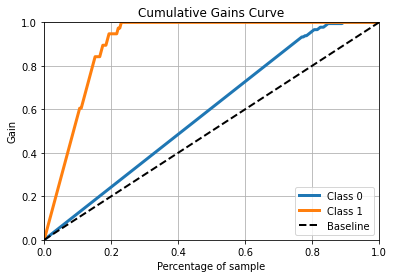

In [85]:
#gain and lift curve plots for the Random Forest

skplt.metrics.plot_cumulative_gain(Y1,rf_grid.predict_proba(X1))
plt.show()

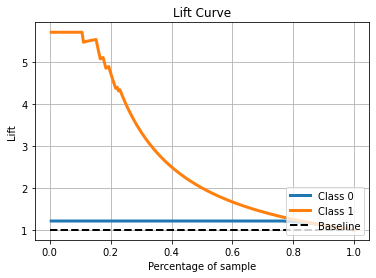

In [86]:
skplt.metrics.plot_lift_curve(Y1,rf_grid.predict_proba(X1))
plt.show()

### Catboost MultiClass Classifier With All Targets

In [87]:
print((data2['Target']).unique())

['Walking' 'Mixed walking' 'Jogging' 'Climbing down' 'Climbing up'
 'Stairs up' 'Stairs down' 'Mixed walking  includes stairs up ' 'Sitting'
 'Mixed walking  with little pauses ' 'Standing' 'No activity']


In [88]:
data2.Target[data2.Target == 'Mixed walking  with little pauses '] = 0

data2.Target[data2.Target == 'Walking'] = 9
data2.Target[data2.Target == 'Mixed walking'] = 10
data2.Target[data2.Target == 'Mixed walking  includes stairs up '] = 11

data2.Target[data2.Target == 'Climbing down'] = 5
data2.Target[data2.Target == 'Climbing up'] = 6
data2.Target[data2.Target == 'Stairs up'] = 7
data2.Target[data2.Target == 'Stairs down'] = 8

data2.Target[data2.Target == 'Jogging'] = 1
data2.Target[data2.Target == 'Sitting'] = 2
data2.Target[data2.Target == 'Standing'] = 3
data2.Target[data2.Target == 'No activity'] = 4

In [89]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

In [90]:
catboost_df = data2.copy()

In [91]:
catboost_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 61 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   s1_mean            2408 non-null   float64
 1   s2_mean            2408 non-null   float64
 2   s3_mean            2408 non-null   float64
 3   x_mean             2408 non-null   float64
 4   y_mean             2408 non-null   float64
 5   z_mean             2408 non-null   float64
 6   s1_variation       2408 non-null   float64
 7   s2_variation       2408 non-null   float64
 8   s3_variation       2408 non-null   float64
 9   x_variation        2408 non-null   float64
 10  y_variation        2408 non-null   float64
 11  s1_std             2408 non-null   float64
 12  x_std              2408 non-null   float64
 13  s1_median          2408 non-null   float64
 14  s3_median          2408 non-null   float64
 15  x_median           2408 non-null   float64
 16  y_max              2408 

In [92]:
catboost_df = catboost_df.astype({'y_max': float, 'z_max': float, 's1_min': float, 'x_min': float, 'z_min': float,
                                 'x_peak_len_20_150': float})
catboost_df = catboost_df.astype({'Target': int})

In [93]:
#sepparating data
Y=catboost_df["Target"]
X=catboost_df.drop("Target",axis=1)

In [94]:
#splitting the data
#split Y into two parts - get Y0, Y1 
#split X into two parts - get X0, Y0 
#X1,Y1-> test, X0, Y0-> train
Y1=Y[:217]
Y0=Y[-2191:]
X1=X[:217]
X0=X[-2191:]

In [95]:
#indicating which features are not categorical
categorical_features_indices = np.where(X0.dtypes != np.float)[0]
train_pool = Pool(X0, Y0, cat_features=categorical_features_indices)

#model
cat = CatBoostClassifier()
cat.fit(train_pool)

#make prediction for evaluation
y_pred_cat = cat.predict(X1)

Learning rate set to 0.082356
0:	learn: 2.0867347	total: 224ms	remaining: 3m 43s
1:	learn: 1.9140786	total: 299ms	remaining: 2m 29s
2:	learn: 1.7933819	total: 368ms	remaining: 2m 2s
3:	learn: 1.6935922	total: 442ms	remaining: 1m 50s
4:	learn: 1.5889944	total: 520ms	remaining: 1m 43s
5:	learn: 1.5085681	total: 592ms	remaining: 1m 38s
6:	learn: 1.4370044	total: 667ms	remaining: 1m 34s
7:	learn: 1.3616641	total: 743ms	remaining: 1m 32s
8:	learn: 1.3068833	total: 814ms	remaining: 1m 29s
9:	learn: 1.2558176	total: 889ms	remaining: 1m 27s
10:	learn: 1.2037221	total: 963ms	remaining: 1m 26s
11:	learn: 1.1624847	total: 1.05s	remaining: 1m 26s
12:	learn: 1.1236276	total: 1.16s	remaining: 1m 27s
13:	learn: 1.0814972	total: 1.26s	remaining: 1m 28s
14:	learn: 1.0437287	total: 1.35s	remaining: 1m 28s
15:	learn: 1.0084926	total: 1.44s	remaining: 1m 28s
16:	learn: 0.9777528	total: 1.53s	remaining: 1m 28s
17:	learn: 0.9551981	total: 1.65s	remaining: 1m 29s
18:	learn: 0.9308567	total: 1.75s	remaining: 

159:	learn: 0.2231236	total: 14s	remaining: 1m 13s
160:	learn: 0.2213445	total: 14.1s	remaining: 1m 13s
161:	learn: 0.2206365	total: 14.2s	remaining: 1m 13s
162:	learn: 0.2200743	total: 14.3s	remaining: 1m 13s
163:	learn: 0.2189884	total: 14.4s	remaining: 1m 13s
164:	learn: 0.2181125	total: 14.5s	remaining: 1m 13s
165:	learn: 0.2168556	total: 14.5s	remaining: 1m 13s
166:	learn: 0.2161065	total: 14.6s	remaining: 1m 12s
167:	learn: 0.2157054	total: 14.7s	remaining: 1m 12s
168:	learn: 0.2144269	total: 14.8s	remaining: 1m 12s
169:	learn: 0.2140251	total: 14.9s	remaining: 1m 12s
170:	learn: 0.2130198	total: 14.9s	remaining: 1m 12s
171:	learn: 0.2120573	total: 15s	remaining: 1m 12s
172:	learn: 0.2109604	total: 15.1s	remaining: 1m 12s
173:	learn: 0.2101474	total: 15.2s	remaining: 1m 12s
174:	learn: 0.2088231	total: 15.3s	remaining: 1m 12s
175:	learn: 0.2077204	total: 15.4s	remaining: 1m 11s
176:	learn: 0.2070930	total: 15.4s	remaining: 1m 11s
177:	learn: 0.2062531	total: 15.5s	remaining: 1m 1

318:	learn: 0.1254721	total: 26.7s	remaining: 56.9s
319:	learn: 0.1252030	total: 26.7s	remaining: 56.8s
320:	learn: 0.1248084	total: 26.8s	remaining: 56.7s
321:	learn: 0.1244125	total: 26.9s	remaining: 56.6s
322:	learn: 0.1239561	total: 27s	remaining: 56.5s
323:	learn: 0.1235827	total: 27s	remaining: 56.4s
324:	learn: 0.1232038	total: 27.1s	remaining: 56.3s
325:	learn: 0.1228838	total: 27.2s	remaining: 56.3s
326:	learn: 0.1226466	total: 27.3s	remaining: 56.2s
327:	learn: 0.1222846	total: 27.4s	remaining: 56.2s
328:	learn: 0.1219111	total: 27.5s	remaining: 56.1s
329:	learn: 0.1215976	total: 27.6s	remaining: 56s
330:	learn: 0.1213534	total: 27.7s	remaining: 56s
331:	learn: 0.1207963	total: 27.8s	remaining: 55.9s
332:	learn: 0.1204232	total: 27.9s	remaining: 55.8s
333:	learn: 0.1200926	total: 28s	remaining: 55.8s
334:	learn: 0.1197519	total: 28s	remaining: 55.7s
335:	learn: 0.1194705	total: 28.1s	remaining: 55.6s
336:	learn: 0.1190775	total: 28.2s	remaining: 55.5s
337:	learn: 0.1187271	to

477:	learn: 0.0835951	total: 40s	remaining: 43.7s
478:	learn: 0.0833264	total: 40.1s	remaining: 43.6s
479:	learn: 0.0831023	total: 40.2s	remaining: 43.6s
480:	learn: 0.0829183	total: 40.3s	remaining: 43.5s
481:	learn: 0.0827043	total: 40.4s	remaining: 43.4s
482:	learn: 0.0824935	total: 40.5s	remaining: 43.3s
483:	learn: 0.0823611	total: 40.5s	remaining: 43.2s
484:	learn: 0.0822009	total: 40.6s	remaining: 43.1s
485:	learn: 0.0819893	total: 40.7s	remaining: 43.1s
486:	learn: 0.0818084	total: 40.8s	remaining: 43s
487:	learn: 0.0816596	total: 40.9s	remaining: 42.9s
488:	learn: 0.0815232	total: 41s	remaining: 42.8s
489:	learn: 0.0813726	total: 41.1s	remaining: 42.8s
490:	learn: 0.0811790	total: 41.2s	remaining: 42.7s
491:	learn: 0.0809818	total: 41.3s	remaining: 42.6s
492:	learn: 0.0808060	total: 41.4s	remaining: 42.5s
493:	learn: 0.0806733	total: 41.5s	remaining: 42.5s
494:	learn: 0.0805207	total: 41.5s	remaining: 42.4s
495:	learn: 0.0803435	total: 41.6s	remaining: 42.3s
496:	learn: 0.0802

637:	learn: 0.0594103	total: 54.7s	remaining: 31s
638:	learn: 0.0592761	total: 54.8s	remaining: 30.9s
639:	learn: 0.0591898	total: 54.9s	remaining: 30.9s
640:	learn: 0.0590877	total: 55s	remaining: 30.8s
641:	learn: 0.0589105	total: 55s	remaining: 30.7s
642:	learn: 0.0588329	total: 55.1s	remaining: 30.6s
643:	learn: 0.0586662	total: 55.2s	remaining: 30.5s
644:	learn: 0.0585782	total: 55.3s	remaining: 30.4s
645:	learn: 0.0584481	total: 55.4s	remaining: 30.3s
646:	learn: 0.0582137	total: 55.4s	remaining: 30.2s
647:	learn: 0.0581068	total: 55.5s	remaining: 30.2s
648:	learn: 0.0579601	total: 55.6s	remaining: 30.1s
649:	learn: 0.0578902	total: 55.7s	remaining: 30s
650:	learn: 0.0577347	total: 55.8s	remaining: 29.9s
651:	learn: 0.0576389	total: 55.9s	remaining: 29.8s
652:	learn: 0.0575851	total: 55.9s	remaining: 29.7s
653:	learn: 0.0574812	total: 56s	remaining: 29.6s
654:	learn: 0.0573820	total: 56.1s	remaining: 29.6s
655:	learn: 0.0572609	total: 56.2s	remaining: 29.5s
656:	learn: 0.0571920	

798:	learn: 0.0437994	total: 1m 8s	remaining: 17.3s
799:	learn: 0.0437512	total: 1m 9s	remaining: 17.3s
800:	learn: 0.0436860	total: 1m 9s	remaining: 17.2s
801:	learn: 0.0436208	total: 1m 9s	remaining: 17.1s
802:	learn: 0.0436014	total: 1m 9s	remaining: 17s
803:	learn: 0.0435408	total: 1m 9s	remaining: 16.9s
804:	learn: 0.0434500	total: 1m 9s	remaining: 16.8s
805:	learn: 0.0433705	total: 1m 9s	remaining: 16.7s
806:	learn: 0.0433167	total: 1m 9s	remaining: 16.6s
807:	learn: 0.0432548	total: 1m 9s	remaining: 16.6s
808:	learn: 0.0431711	total: 1m 9s	remaining: 16.5s
809:	learn: 0.0430939	total: 1m 9s	remaining: 16.4s
810:	learn: 0.0430328	total: 1m 9s	remaining: 16.3s
811:	learn: 0.0429403	total: 1m 10s	remaining: 16.2s
812:	learn: 0.0429266	total: 1m 10s	remaining: 16.1s
813:	learn: 0.0428878	total: 1m 10s	remaining: 16s
814:	learn: 0.0428357	total: 1m 10s	remaining: 16s
815:	learn: 0.0427683	total: 1m 10s	remaining: 15.9s
816:	learn: 0.0426950	total: 1m 10s	remaining: 15.8s
817:	learn: 

954:	learn: 0.0345107	total: 1m 23s	remaining: 3.92s
955:	learn: 0.0344714	total: 1m 23s	remaining: 3.84s
956:	learn: 0.0344421	total: 1m 23s	remaining: 3.75s
957:	learn: 0.0344219	total: 1m 23s	remaining: 3.66s
958:	learn: 0.0343834	total: 1m 23s	remaining: 3.58s
959:	learn: 0.0343459	total: 1m 23s	remaining: 3.49s
960:	learn: 0.0342869	total: 1m 23s	remaining: 3.4s
961:	learn: 0.0342555	total: 1m 23s	remaining: 3.31s
962:	learn: 0.0341881	total: 1m 24s	remaining: 3.23s
963:	learn: 0.0341635	total: 1m 24s	remaining: 3.14s
964:	learn: 0.0340942	total: 1m 24s	remaining: 3.05s
965:	learn: 0.0340622	total: 1m 24s	remaining: 2.97s
966:	learn: 0.0340154	total: 1m 24s	remaining: 2.88s
967:	learn: 0.0339845	total: 1m 24s	remaining: 2.79s
968:	learn: 0.0339243	total: 1m 24s	remaining: 2.71s
969:	learn: 0.0338706	total: 1m 24s	remaining: 2.62s
970:	learn: 0.0338161	total: 1m 24s	remaining: 2.53s
971:	learn: 0.0337216	total: 1m 24s	remaining: 2.44s
972:	learn: 0.0336882	total: 1m 24s	remaining: 

In [96]:
# accuracy
from sklearn.metrics import accuracy_score
print('Accuracy ' + str(accuracy_score(Y1, y_pred_cat)))

Accuracy 0.4976958525345622


### Catboost MultiClass Classifier with Fewer Targets

In [111]:
print((data3['Target']).unique())

['Walking' 'Mixed walking' 'Jogging' 'Climbing down' 'Climbing up'
 'Stairs up' 'Stairs down' 'Mixed walking  includes stairs up ' 'Sitting'
 'Mixed walking  with little pauses ' 'Standing' 'No activity']


In [112]:
data3.Target[(data3.Target == 'Mixed walking  with little pauses ') |
             (data3.Target == 'Walking') |
             (data3.Target == 'Mixed walking') |
             (data3.Target == 'Mixed walking  includes stairs up ')] = 'walking'

data3.Target[(data3.Target == 'Climbing down') |
             (data3.Target == 'Stairs down')] = 'up'

data3.Target[(data3.Target == 'Climbing up') | (data3.Target == 'Stairs up')] = 'down'

data3.Target[data3.Target == 'Jogging'] = 'jogging'

data3.Target[(data3.Target == 'Sitting') |
             (data3.Target == 'Standing') |
             (data3.Target == 'No activity')] = 'passive'

In [113]:
print((data3['Target']).unique())

['walking' 'jogging' 'up' 'down' 'passive']


In [114]:
catboost_df = data3.copy()

In [115]:
catboost_df = catboost_df.astype({'y_max': float, 'z_max': float, 's1_min': float, 'x_min': float, 'z_min': float,
                                 'x_peak_len_20_150': float})


In [116]:
#sepparating data
Y=catboost_df["Target"]
X=catboost_df.drop("Target",axis=1)

In [117]:
#splitting the data
#split Y into two parts - get Y0, Y1 
#split X into two parts - get X0, Y0 
#X1,Y1-> test, X0, Y0-> train
Y1=Y[:217]
Y0=Y[-2191:]
X1=X[:217]
X0=X[-2191:]

In [118]:
#indicating which features are not categorical
categorical_features_indices = np.where(X0.dtypes != np.float)[0]
train_pool = Pool(X0, Y0, cat_features=categorical_features_indices)

#model
cat = CatBoostClassifier()
cat.fit(train_pool)

#make prediction for evaluation
y_pred_cat = cat.predict(X1)

Learning rate set to 0.082356
0:	learn: 1.4300976	total: 65.4ms	remaining: 1m 5s
1:	learn: 1.2975605	total: 113ms	remaining: 56.2s
2:	learn: 1.1966842	total: 153ms	remaining: 50.8s
3:	learn: 1.1080932	total: 198ms	remaining: 49.2s
4:	learn: 1.0372487	total: 247ms	remaining: 49.1s
5:	learn: 0.9763907	total: 291ms	remaining: 48.2s
6:	learn: 0.9143430	total: 354ms	remaining: 50.2s
7:	learn: 0.8621969	total: 407ms	remaining: 50.4s
8:	learn: 0.8175421	total: 459ms	remaining: 50.6s
9:	learn: 0.7732514	total: 510ms	remaining: 50.5s
10:	learn: 0.7345698	total: 560ms	remaining: 50.4s
11:	learn: 0.7009531	total: 612ms	remaining: 50.4s
12:	learn: 0.6754313	total: 714ms	remaining: 54.2s
13:	learn: 0.6435120	total: 763ms	remaining: 53.7s
14:	learn: 0.6150112	total: 811ms	remaining: 53.2s
15:	learn: 0.5910873	total: 862ms	remaining: 53s
16:	learn: 0.5717387	total: 905ms	remaining: 52.3s
17:	learn: 0.5520383	total: 955ms	remaining: 52.1s
18:	learn: 0.5384573	total: 1.02s	remaining: 52.5s
19:	learn: 0

162:	learn: 0.1253027	total: 8.06s	remaining: 41.4s
163:	learn: 0.1241867	total: 8.11s	remaining: 41.4s
164:	learn: 0.1234705	total: 8.16s	remaining: 41.3s
165:	learn: 0.1224510	total: 8.21s	remaining: 41.3s
166:	learn: 0.1215214	total: 8.26s	remaining: 41.2s
167:	learn: 0.1210684	total: 8.32s	remaining: 41.2s
168:	learn: 0.1205944	total: 8.4s	remaining: 41.3s
169:	learn: 0.1200946	total: 8.45s	remaining: 41.2s
170:	learn: 0.1197228	total: 8.49s	remaining: 41.2s
171:	learn: 0.1191311	total: 8.55s	remaining: 41.2s
172:	learn: 0.1183090	total: 8.6s	remaining: 41.1s
173:	learn: 0.1174621	total: 8.65s	remaining: 41s
174:	learn: 0.1168201	total: 8.71s	remaining: 41s
175:	learn: 0.1166590	total: 8.75s	remaining: 41s
176:	learn: 0.1156248	total: 8.8s	remaining: 40.9s
177:	learn: 0.1151306	total: 8.84s	remaining: 40.8s
178:	learn: 0.1147356	total: 8.88s	remaining: 40.7s
179:	learn: 0.1144817	total: 8.92s	remaining: 40.7s
180:	learn: 0.1141422	total: 8.98s	remaining: 40.6s
181:	learn: 0.1139381

322:	learn: 0.0699675	total: 15.7s	remaining: 32.9s
323:	learn: 0.0697488	total: 15.7s	remaining: 32.8s
324:	learn: 0.0695298	total: 15.8s	remaining: 32.8s
325:	learn: 0.0692825	total: 15.8s	remaining: 32.7s
326:	learn: 0.0691900	total: 15.9s	remaining: 32.7s
327:	learn: 0.0687332	total: 15.9s	remaining: 32.6s
328:	learn: 0.0685640	total: 16s	remaining: 32.5s
329:	learn: 0.0684627	total: 16s	remaining: 32.5s
330:	learn: 0.0681964	total: 16.1s	remaining: 32.5s
331:	learn: 0.0679732	total: 16.1s	remaining: 32.4s
332:	learn: 0.0677905	total: 16.1s	remaining: 32.3s
333:	learn: 0.0676245	total: 16.2s	remaining: 32.3s
334:	learn: 0.0673243	total: 16.2s	remaining: 32.2s
335:	learn: 0.0671415	total: 16.3s	remaining: 32.2s
336:	learn: 0.0667894	total: 16.3s	remaining: 32.1s
337:	learn: 0.0665495	total: 16.4s	remaining: 32.1s
338:	learn: 0.0663745	total: 16.4s	remaining: 32s
339:	learn: 0.0661762	total: 16.5s	remaining: 32s
340:	learn: 0.0660827	total: 16.5s	remaining: 31.9s
341:	learn: 0.065886

483:	learn: 0.0431979	total: 23.1s	remaining: 24.6s
484:	learn: 0.0431365	total: 23.1s	remaining: 24.5s
485:	learn: 0.0429725	total: 23.1s	remaining: 24.5s
486:	learn: 0.0429319	total: 23.2s	remaining: 24.4s
487:	learn: 0.0428110	total: 23.2s	remaining: 24.4s
488:	learn: 0.0427171	total: 23.3s	remaining: 24.3s
489:	learn: 0.0425927	total: 23.3s	remaining: 24.3s
490:	learn: 0.0425590	total: 23.4s	remaining: 24.2s
491:	learn: 0.0425011	total: 23.4s	remaining: 24.2s
492:	learn: 0.0423125	total: 23.5s	remaining: 24.1s
493:	learn: 0.0422251	total: 23.5s	remaining: 24.1s
494:	learn: 0.0421472	total: 23.6s	remaining: 24s
495:	learn: 0.0419455	total: 23.6s	remaining: 24s
496:	learn: 0.0418594	total: 23.6s	remaining: 23.9s
497:	learn: 0.0417468	total: 23.7s	remaining: 23.9s
498:	learn: 0.0415949	total: 23.8s	remaining: 23.9s
499:	learn: 0.0415171	total: 23.8s	remaining: 23.8s
500:	learn: 0.0414206	total: 23.9s	remaining: 23.8s
501:	learn: 0.0413405	total: 23.9s	remaining: 23.7s
502:	learn: 0.04

644:	learn: 0.0298872	total: 30.4s	remaining: 16.7s
645:	learn: 0.0298270	total: 30.5s	remaining: 16.7s
646:	learn: 0.0297849	total: 30.5s	remaining: 16.6s
647:	learn: 0.0297361	total: 30.5s	remaining: 16.6s
648:	learn: 0.0297052	total: 30.6s	remaining: 16.6s
649:	learn: 0.0296255	total: 30.7s	remaining: 16.5s
650:	learn: 0.0295395	total: 30.7s	remaining: 16.5s
651:	learn: 0.0294617	total: 30.7s	remaining: 16.4s
652:	learn: 0.0294085	total: 30.8s	remaining: 16.4s
653:	learn: 0.0293552	total: 30.8s	remaining: 16.3s
654:	learn: 0.0293238	total: 30.9s	remaining: 16.3s
655:	learn: 0.0292798	total: 30.9s	remaining: 16.2s
656:	learn: 0.0291802	total: 31s	remaining: 16.2s
657:	learn: 0.0291078	total: 31s	remaining: 16.1s
658:	learn: 0.0290340	total: 31.1s	remaining: 16.1s
659:	learn: 0.0289796	total: 31.1s	remaining: 16s
660:	learn: 0.0289309	total: 31.2s	remaining: 16s
661:	learn: 0.0288959	total: 31.2s	remaining: 15.9s
662:	learn: 0.0288259	total: 31.2s	remaining: 15.9s
663:	learn: 0.028753

805:	learn: 0.0218942	total: 38s	remaining: 9.13s
806:	learn: 0.0218458	total: 38s	remaining: 9.09s
807:	learn: 0.0218151	total: 38s	remaining: 9.04s
808:	learn: 0.0217876	total: 38.1s	remaining: 8.99s
809:	learn: 0.0217540	total: 38.1s	remaining: 8.94s
810:	learn: 0.0216979	total: 38.2s	remaining: 8.9s
811:	learn: 0.0216773	total: 38.2s	remaining: 8.85s
812:	learn: 0.0216471	total: 38.3s	remaining: 8.8s
813:	learn: 0.0216198	total: 38.3s	remaining: 8.76s
814:	learn: 0.0216063	total: 38.4s	remaining: 8.71s
815:	learn: 0.0215781	total: 38.4s	remaining: 8.67s
816:	learn: 0.0215589	total: 38.5s	remaining: 8.63s
817:	learn: 0.0215336	total: 38.6s	remaining: 8.58s
818:	learn: 0.0214850	total: 38.6s	remaining: 8.54s
819:	learn: 0.0214666	total: 38.7s	remaining: 8.49s
820:	learn: 0.0214353	total: 38.7s	remaining: 8.44s
821:	learn: 0.0213494	total: 38.8s	remaining: 8.4s
822:	learn: 0.0212936	total: 38.9s	remaining: 8.36s
823:	learn: 0.0212381	total: 38.9s	remaining: 8.31s
824:	learn: 0.0212047

966:	learn: 0.0168306	total: 45.7s	remaining: 1.56s
967:	learn: 0.0168224	total: 45.7s	remaining: 1.51s
968:	learn: 0.0167961	total: 45.8s	remaining: 1.46s
969:	learn: 0.0167781	total: 45.8s	remaining: 1.42s
970:	learn: 0.0167256	total: 45.9s	remaining: 1.37s
971:	learn: 0.0167134	total: 45.9s	remaining: 1.32s
972:	learn: 0.0166813	total: 46s	remaining: 1.27s
973:	learn: 0.0166520	total: 46s	remaining: 1.23s
974:	learn: 0.0166294	total: 46s	remaining: 1.18s
975:	learn: 0.0166120	total: 46.1s	remaining: 1.13s
976:	learn: 0.0165788	total: 46.1s	remaining: 1.08s
977:	learn: 0.0165477	total: 46.2s	remaining: 1.04s
978:	learn: 0.0165337	total: 46.2s	remaining: 992ms
979:	learn: 0.0164958	total: 46.3s	remaining: 944ms
980:	learn: 0.0164908	total: 46.3s	remaining: 897ms
981:	learn: 0.0164778	total: 46.4s	remaining: 850ms
982:	learn: 0.0164577	total: 46.4s	remaining: 802ms
983:	learn: 0.0164431	total: 46.4s	remaining: 755ms
984:	learn: 0.0164062	total: 46.5s	remaining: 708ms
985:	learn: 0.0163

In [119]:
# accuracy
from sklearn.metrics import accuracy_score
print('Accuracy ' + str(accuracy_score(Y1, y_pred_cat)))

Accuracy 0.7695852534562212
